# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe.

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks:
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hottest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain?
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.

# Unpacking data
Note code was resubmitted due to a misunderstanding in task 2 and improvements to code struture and commenting I percived to be worth more than 10%

#1: Pulling data from dataset

In this section I'll unpack the GHCNd dataset with help from the provided code. I'll then turn this dataset into a pandas dataframe to facilitate data manipulation.

---



In [25]:
# import libraries
import urllib.request
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from tensorflow import keras
from google.colab import files

#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country

    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:

    #Class constructor
    def __init__(self):
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)

    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip()
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields

                # For clarity use some variable names
                station=fields[0]
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)

                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy

    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")


    def readStationsFile(self,fileName=None,justGSN=True):

        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')


            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList

    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')

    def printStation(self,sid):
        print(self.stationDict[sid])

    def getStation(self,sid):
        return self.stationDict[sid]

    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]

In [26]:
#Load station file from class functions
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [27]:
#Load and unoack station data as pandas dataframe
def get_station_data(station):
    '''
    Uses getvar function to load a given station's data, indexed from 1-990.
    The loaded data is returned in the form of a pandas dataframe.
    '''
    #Load station data
    # Gets list of station names
    statNames=ghn.getStatKeyNames()
    fileName=statNames[station]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    # Copy a network object to a local file
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)

    # Define variable names and corresponding keys
    elements = []
    variables = {'TMAX': '1', 'TMIN': '2', 'PRCP': '3', 'SNOW': '4', 'SNWD': '5'}

    # Loop through variables
    #Print an exception if station does not have data for corresponding element
    for var_key, var_name in variables.items():
        try:
            var_array = ghn.getVar(statDict, var_key)
            days, var_data = zip(*var_array)
            df_var = pd.DataFrame(var_data, index=days, columns=[var_key])
            elements.append(df_var)
        except KeyError:
            print(f"KeyError occurred for {var_key}")

    return {element.columns[0]: element for element in elements}

#2: Process data and deal with holes

In this section I'll be treating the data in two steps.
First, I'll separate the data in to significant features which are separated by long time gaps.
Second, I'll interpolate the small gaps which exist is the data features.

Number of sub datasets is 5
1293
445
475
1878
1285


Text(0, 0.5, 'Temperature (C)')

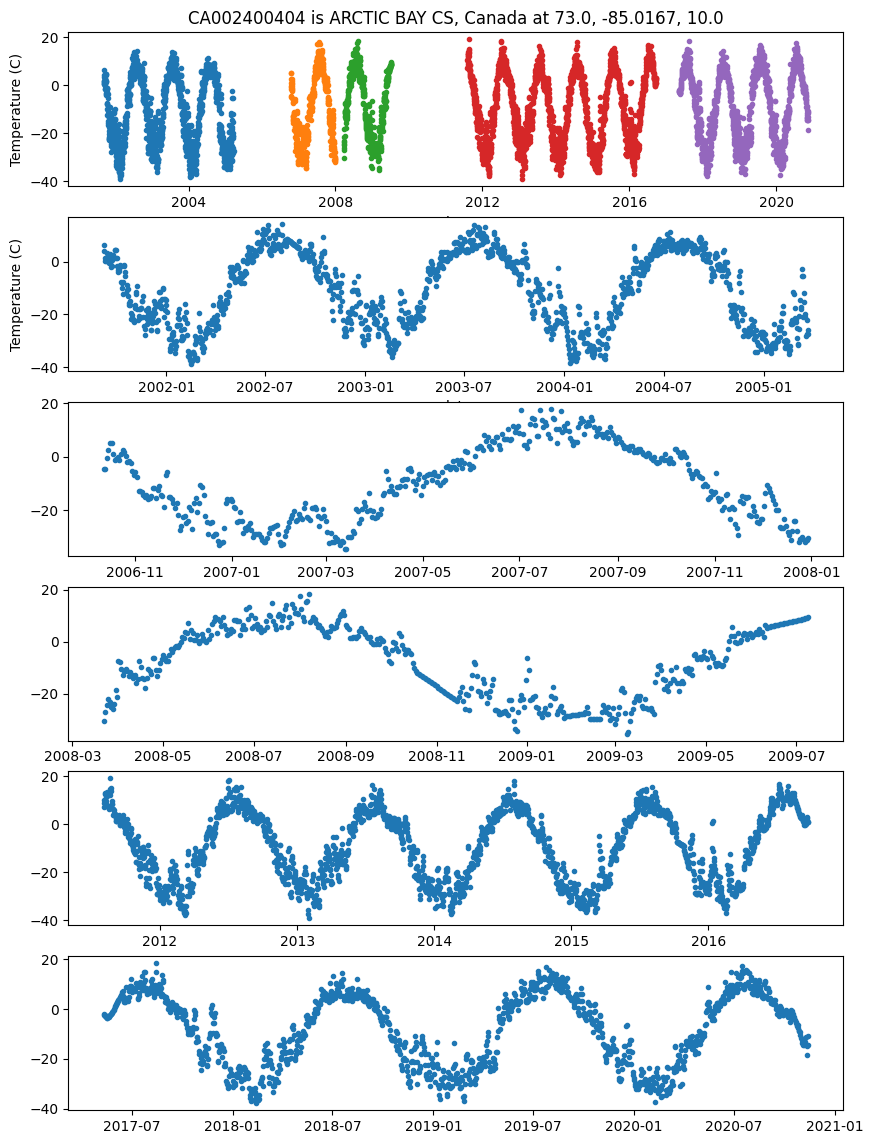

In [4]:
# Load example station data.
# In this case I used TMAX data from station 220 (Arctic Bay,Canada)
station = 220
df_elements = get_station_data(station)

##########################################################################
def split_and_fill_holes(df, maxgap,minsize, timeframe):
    '''
    Split dataset into smaller sets, to avoid training over large gaps defined by maxgap then interpolate to fill gaps
    Returns list of interpolated dataframes of data features.

    df is input dataframe
    maxgap is maximum gap in days before a split
    minsize is the minimum number of datapoints in a split
    timeframe is either daily, monthly or weekly
    '''
    #######
    # Define threshold for maximum number of missing days
    threshold = timedelta(days=maxgap)

    # Initialise arrays and counters
    dfs = []
    indexs = []
    j = 0
    start_idx = 0

    # Check for large gaps over data and then append.
    for i in range(1, len(df)):
      if (df.index[i] - df.index[i-1]) > threshold:
        # If time gap exceeds threshold, create a new sub dataset
        cut = df.iloc[start_idx:i]
        if len(cut) >= minsize:  # Add a caveat to drop the dataset if its too short
          dfs.append(cut)
          j += 1
        start_idx = i + 1

    # Add the last sub dataset
    if start_idx < len(df):
      cut = df.iloc[start_idx:i]
      if len(cut) >= minsize:
          dfs.append(df.iloc[start_idx:])
          j += 1
      else:
        pass

    print(f'Number of sub datasets is {j}')

    ##############
    # Fill in holes and interpolate
    dfis = []
    for df_slice in dfs:
      index_days = pd.date_range(start=df_slice.index.min(), end=df_slice.index.max(), freq='D')
      df_daily = df_slice.reindex(index_days)
      dfi_daily = df_daily.interpolate(method='time', axis=0)
      if timeframe == 'M':
        dfi_monthly = dfi_daily.groupby(pd.Grouper(freq='M')).mean()
        indexs.append(dfi_monthly.index)
        dfis.append(dfi_monthly)
      elif timeframe == 'W':
        dfi_weekly = dfi_daily.groupby(pd.Grouper(freq='W')).mean()
        indexs.append(dfi_weekly.index)
        dfis.append(dfi_weekly)
      elif timeframe == 'D':
        indexs.append(dfi_daily.index)
        dfis.append(dfi_daily)
      else:
        raise ValueError('Invalid timeframe. Please enter D (Days), W (Weeks), or M (Months).')

    return (indexs, dfis)
#####################################################################################################

timeframe = 'D' #Can be 'D','W' or 'M' for daily, monthly and weekly
indexs,dfis = split_and_fill_holes(df_elements['TMAX'],30,365,timeframe)

#Plot datasets
fig, ax = plt.subplots(len(dfis)+1,1,figsize=(10, 14))
statNames=ghn.getStatKeyNames()

# Loop through separated dataframes
for i in range (0,len(dfis)):
  ax[0].plot(dfis[i],'.')
  ax[i+1].plot(dfis[i],'.')
  print(len(dfis[i]))

ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[station]))
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

#3: Prepare data for LSTM
In this section I'll take the dataframes created in the previous part and set it up for the LSTM.
This will be done in two parts:
One, split data into overlapping set of target and label windows.
Two, split the data into training, validation and test sets.

In [5]:
# Define some useful functions
def unpack_df(df):
    #Unpacks data from dataframe
    var = df.iloc[:,0]
    days = df.index
    return(days,var)

def split_dataset(data, train_ratio, val_ratio):
    """
    Split a dataset into training, validation, and test sets.
    """
    data_length = len(data)
    train_size = int(data_length * train_ratio)
    val_size = int(data_length * val_ratio)
    test_size = data_length - train_size - val_size

    # Split the data
    train_set = data[:train_size]
    val_set = data[train_size:train_size + val_size]
    test_set = data[-test_size:]

    return (train_set, val_set, test_set)

def shape_array(x, window_size, offset):
    """
    This function splits up a 1-D array x into a series of overlapping windows.
    The return is a tuple of the array of input windows and target (label) windows.
    """
    x_input = np.array([x[i : i + window_size] for i in range(len(x) - (window_size + offset) + 1)])
    x_label = np.array([x[i + window_size : i + window_size + offset] for i in range(len(x) - (window_size + offset) + 1)])
    return (x_input, x_label)


def mise_en_place(dfs, window_size, offset, train_ratio, val_ratio):
    """
    Prepares data for LSTM.
    Inputs list of dataframes from split_and_fill_holes and returns prepared datasets.
    Mise en place refers to the steps taken before cooking in a kitchen
    """
    data_inputs = []
    data_labels = []
    indexs = []

    # Unpack dataframes, then shape and combine data
    for df in dfs:
        index, data = unpack_df(df)
        data_input, data_label = shape_array(data, window_size, offset)
        data_inputs.append(data_input)
        data_labels.append(data_label)

    # Turn into arrays
    data_inputs = np.concatenate(data_inputs, axis=0)
    data_labels = np.concatenate(data_labels, axis=0)

    # Split pre-split arrays into train, validation, and test sets
    train_input, val_input, test_input = split_dataset(data_inputs, train_ratio, val_ratio)
    train_label, val_label, test_label = split_dataset(data_labels, train_ratio, val_ratio)

    train_target = train_label[:, -1]
    val_target = val_label[:, -1]
    test_target = test_label[:, -1]

    return {
        'train_input': train_input,
        'train_target': train_target,
        'val_input': val_input,
        'val_target': val_target,
        'test_input': test_input,
        'test_target': test_target,
    }

def table_for_one(df, window_size, offset, train_ratio, val_ratio):
    """
    Functionally the same as mise en place but takes in only a single dataframe.
    Also includes a caveat that allows traing and validation sets to be zero, allowing for dataframe to be turned into one large test set.
    """
    index,data = unpack_df(df)
    # Train, Test, Val split
    train_data, val_data, test_data = split_dataset(data, train_ratio, val_ratio)

    # Shape arrays
    train_input, train_label = shape_array(train_data, window_size, offset)
    val_input, val_label = shape_array(val_data, window_size, offset)
    test_input, test_label = shape_array(test_data, window_size, offset)

    if train_ratio != 0: #Helpful little sniipit which allows me to preapre a data chunk as a massive test set
      train_target = train_label[:, -1]
      val_target = val_label[:, -1]
    else:
      train_target = 0
      val_target = 0

    test_target = test_label[:, -1]

    return {
        'train_input': train_input,
        'train_target': train_target,
        'val_input': val_input,
        'val_target': val_target,
        'test_input': test_input,
        'test_target': test_target,
     }

#4: Train and plot model

In this section I will train the model on the provided data and plot the results against the known data.

In [6]:
# Define LSTM model and params
offset = 7
window_size = 5
train_rat = 0.7
val_rat = 0.15
params = mise_en_place(dfis,window_size,offset,train_rat,val_rat)


def Delphi():
    '''
    Function that creates and returns model
    Named after oracle of Delphi
    '''
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(512, input_shape=(None, 1), return_sequences=True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.LSTM(256, return_sequences=True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.LSTM(128, return_sequences=True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(64, return_sequences=True))
    model.add(keras.layers.LSTM(32))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1, activation="linear")) # Dense layer needs to be 1 to return single prediction array

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam') # Used RMS for error and adam as optimiser
    return (model)

In [7]:
#Reset and train model
# Since we have daily data I used a large batch size to relect large data set.
model = Delphi()
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(params['train_input'],params['train_target'],batch_size=32,epochs=20,verbose = 1,validation_data=(params['val_input'], params['val_target']))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 512)         1052672   
                                                                 
 batch_normalization (Batch  (None, None, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         787456    
                                                                 
 batch_normalization_1 (Bat  (None, None, 256)         1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0

25/25 [==============================] - 2s 5ms/step
rms of test set is 5.92055162778578


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


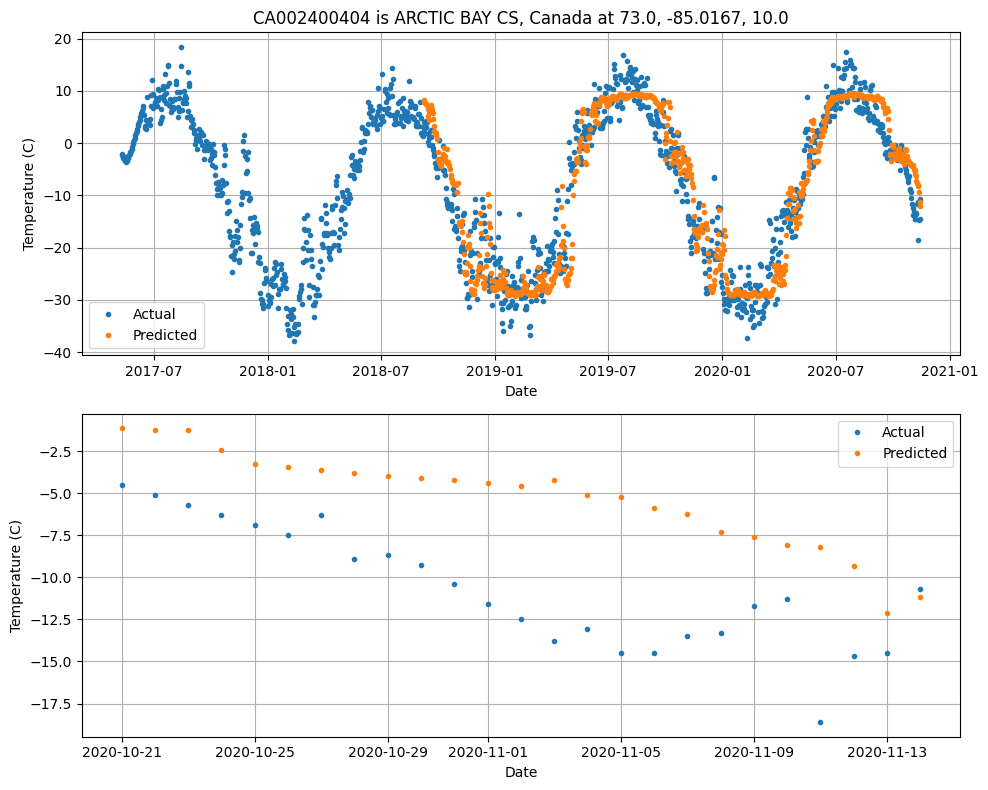

In [8]:
# Plot test prediction
########################################################
def model_test(test_input,dfis,indexs,timeframe):
    '''
    Takes in test set from mise en place and indexs from split and fill holes
    Returns dataframe of predicted values.
    '''
    predicted = model.predict(test_input)
    end_daysp = indexs[-1][-1]

    if timeframe == 'D':
      start_daysp = end_daysp - pd.Timedelta(days =+ len(predicted))
      predicted_dates = pd.date_range(start=start_daysp, end=end_daysp, freq = 'D')
    elif timeframe == 'W':
      start_daysp = end_daysp - pd.Timedelta(weeks =+ len(predicted))
      predicted_dates = pd.date_range(start=start_daysp, end=end_daysp, freq = 'W')
    elif timeframe == 'M':
      start_daysp = end_daysp - relativedelta(months =+ len(predicted))
      predicted_dates = pd.date_range(start=start_daysp, end=end_daysp, freq = 'M')
    else:
      raise ValueError('Invalid timeframe. Please enter D (Days), W (Weeks), or M (Months).')
    if len(predicted_dates) != len(predicted): #Deals with rounding errors
      predicted_dates = predicted_dates[1:]

    # Calculate RMS (test loss)
    rms = np.sqrt(np.mean((predicted - dfis[-1][-len(predicted):])**2))
    print(f'rms of test set is {rms.iloc[0]}')
    return (pd.DataFrame(predicted, index=predicted_dates),rms.iloc[0])
########################################################

dfp,rmsm = model_test(params['test_input'],dfis,indexs,timeframe)

# Plot the actual and predicted values
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(dfis[-1], '.', label="Actual")
ax[0].plot(dfp, '.', label="Predicted")
# ax[0].plot(dfis[-1][-offset:], '.', label="Targets")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[station]))
ax[0].legend()
ax[0].grid(True)

# Plot the zoom in
zoom = 25 #plot last x number of points
ax[1].plot(dfis[-1][-zoom:], '.', label="Actual")
ax[1].plot(dfp[-zoom:], '.', label="Predicted")
# ax[1].plot(dfis[-1][-offset:], '.', label="Targets")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Temperature (C)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()

In [9]:
# Compress all of above code into functions
def GHCNd_predict_load_data(station, element, max_gap, min_length, timeframe):
    # Define graph units for all elements
    element_units = {
    'TMAX': 'Temperature (°C)',
    'TMIN': 'Temperature (°C)',
    'PRCP': 'Precipitation (mm)',
    'SNOW': 'Snow Depth (mm)',
    'SNWD': 'Snow Depth (mm)'
    }

    # Load raw station data
    station = station  # Pick station indexed from 1-990
    df = get_station_data(station)

    # Fill holes and plot
    indexs, dfis = split_and_fill_holes(df[element], max_gap, min_length, timeframe)

    fig, ax = plt.subplots(len(dfis)+1,1,figsize=(10, 14))
    for i in range (0,len(dfis)):
      ax[0].plot(dfis[i],'.')
      ax[i+1].plot(dfis[i],'.')
      ax[i+1].grid(True)
      print(len(dfis[i]))

    ax[0].set_xlabel("date")
    ax[0].set_ylabel(element_units[element])
    ax[0].set_title(ghn.getStation(statNames[station]))
    ax[0].grid(True)

    return indexs, dfis

def GHCNd_predict_train(indexs, dfis, offset, window_size, train_ratio, val_ratio, batch_size, epochs):
    # Reset and train model
    params = mise_en_place(dfis, window_size, offset, train_ratio, val_ratio)
    # print(len(params['train_input'])) #debugging prints
    # print(len(params['val_input']))
    # print(len(params['test_input']))
    history = model.fit(params['train_input'], params['train_target'], batch_size=batch_size, epochs=epochs,
                        verbose=1, validation_data=(params['val_input'], params['val_target']))
    # # Get loss data for verbose = 0
    # last_epochs = 5
    # print("Last 5 Training Losses:".format(last_epochs), history.history['loss'][-last_epochs:])
    # print("Last 5 Validation Losses:".format(last_epochs), history.history['val_loss'][-last_epochs:])
    return params['test_input']

def GHCNd_predict_plot(element,test_input,dfis, timeframe, zoom):
    element_units = {
    'TMAX': 'Temperature (°C)',
    'TMIN': 'Temperature (°C)',
    'PRCP': 'Precipitation (mm)',
    'SNOW': 'Snow Depth (mm)',
    'SNWD': 'Snow Depth (mm)'
    }

    # Plot the actual and predicted values
    dfp,rmsm = model_test(test_input,dfis, indexs, timeframe)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(dfis[-1], '.', label="Actual")
    ax[0].plot(dfp, '.', label="Predicted")
    ax[0].set_xlabel("Date")
    ax[0].set_ylabel(element_units[element])
    ax[0].set_title(ghn.getStation(statNames[station]))
    ax[0].legend()
    ax[0].grid(True)

    # Plot the zoom in
    zoom = zoom  # plot last x number of points
    ax[1].plot(dfis[-1][-zoom:], '.', label="Actual")
    ax[1].plot(dfp[-zoom:], '.', label="Predicted")
    ax[1].set_xlabel("Date")
    ax[1].set_ylabel(element_units[element])
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    return(dfp)

#5: Task 1

In this part I'll be using the above code to make predictions for two years into the future.
This was done with monthly climate for TMIN and TMAX
And weekly for PRCP and SNOW

#TMAX station 666

KeyError occurred for SNOW
Number of sub datasets is 4
148
111
578
222


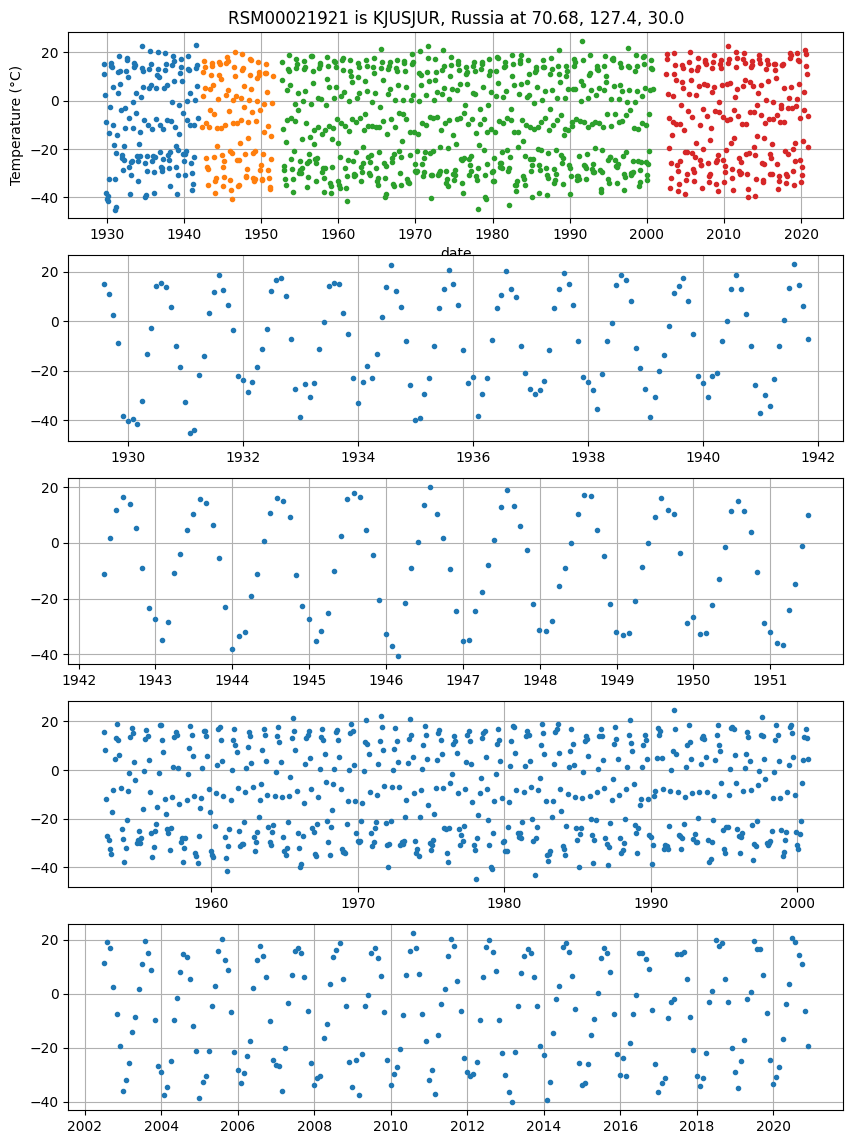

In [10]:
#Define all vars
station = 666
element = 'TMAX'
max_gap = 64
min_length = 365
timeframe = 'M'

# Pull data and train model
indexs,dfis = GHCNd_predict_load_data(station,element,max_gap,min_length,timeframe)

In [11]:
#Reset and train model
model = Delphi()
model.compile(loss='mean_squared_error', optimizer='adam')
test_input = GHCNd_predict_train(indexs, dfis, offset = 24, window_size = 12, train_ratio = 0.7, val_ratio = 0.15, batch_size = 5, epochs = 20)

Epoch 1/20
129/129 [==============================] - 16s 32ms/step - loss: 280.0816 - val_loss: 320.6827
Epoch 2/20
129/129 [==============================] - 3s 20ms/step - loss: 160.6293 - val_loss: 203.6852
Epoch 3/20
129/129 [==============================] - 3s 22ms/step - loss: 139.5938 - val_loss: 153.0818
Epoch 4/20
129/129 [==============================] - 2s 19ms/step - loss: 134.9325 - val_loss: 93.1971
Epoch 5/20
129/129 [==============================] - 2s 19ms/step - loss: 121.9276 - val_loss: 48.7616
Epoch 6/20
129/129 [==============================] - 3s 20ms/step - loss: 107.7429 - val_loss: 21.4449
Epoch 7/20
129/129 [==============================] - 3s 25ms/step - loss: 115.2872 - val_loss: 17.8140
Epoch 8/20
129/129 [==============================] - 3s 20ms/step - loss: 113.9696 - val_loss: 83.6566
Epoch 9/20
129/129 [==============================] - 3s 20ms/step - loss: 117.3394 - val_loss: 25.4714
Epoch 10/20
129/129 [==============================] - 3s 20

5/5 [==============================] - 2s 6ms/step
rms of test set is 4.391726363073823


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


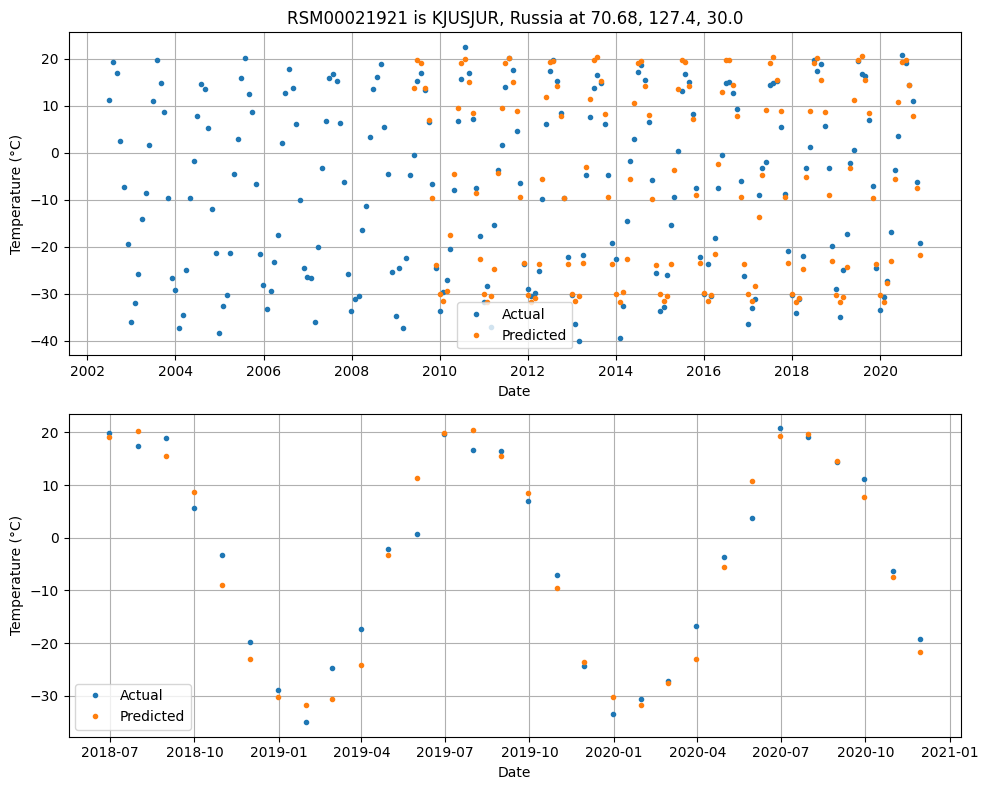

In [12]:
# Plot and compare
dfp = GHCNd_predict_plot(element,test_input,dfis,timeframe, zoom = 30)

# PRCP station 39

KeyError occurred for SNOW
Number of sub datasets is 4
86
1163
226
604


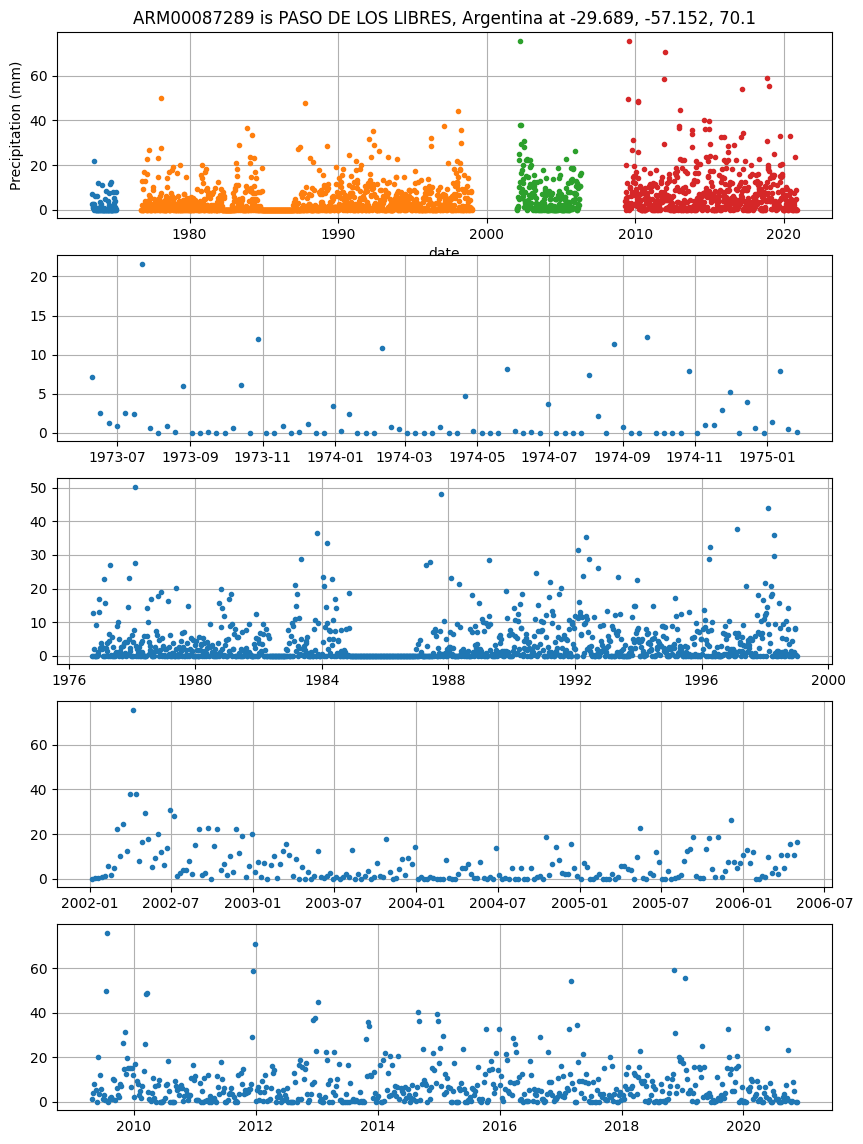

In [13]:
#Define all vars
station = 39
element = 'PRCP'
max_gap = 30
min_length = 365
timeframe = 'W'

# Pull data and train model
indexs,dfis = GHCNd_predict_load_data(station,element,max_gap,min_length,timeframe)

In [14]:
# Reset and train model
model = Delphi()
model.compile(loss='mean_squared_error', optimizer='adam')
test_input = GHCNd_predict_train(indexs, dfis, offset = 52, window_size = 12, train_ratio = 0.7, val_ratio = 0.15, batch_size = 20, epochs = 20)

Epoch 1/20
64/64 [==============================] - 14s 45ms/step - loss: 51.5671 - val_loss: 137.8774
Epoch 2/20
64/64 [==============================] - 1s 18ms/step - loss: 47.1475 - val_loss: 128.2793
Epoch 3/20
64/64 [==============================] - 1s 23ms/step - loss: 44.4526 - val_loss: 117.7876
Epoch 4/20
64/64 [==============================] - 1s 23ms/step - loss: 42.0468 - val_loss: 118.2938
Epoch 5/20
64/64 [==============================] - 1s 19ms/step - loss: 39.9379 - val_loss: 115.2641
Epoch 6/20
64/64 [==============================] - 1s 19ms/step - loss: 39.1174 - val_loss: 114.9004
Epoch 7/20
64/64 [==============================] - 1s 19ms/step - loss: 39.5971 - val_loss: 116.7280
Epoch 8/20
64/64 [==============================] - 1s 19ms/step - loss: 38.3836 - val_loss: 110.3148
Epoch 9/20
64/64 [==============================] - 1s 19ms/step - loss: 37.9955 - val_loss: 111.8202
Epoch 10/20
64/64 [==============================] - 1s 19ms/step - loss: 38.4438

9/9 [==============================] - 2s 7ms/step
rms of test set is 10.548432101277958


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


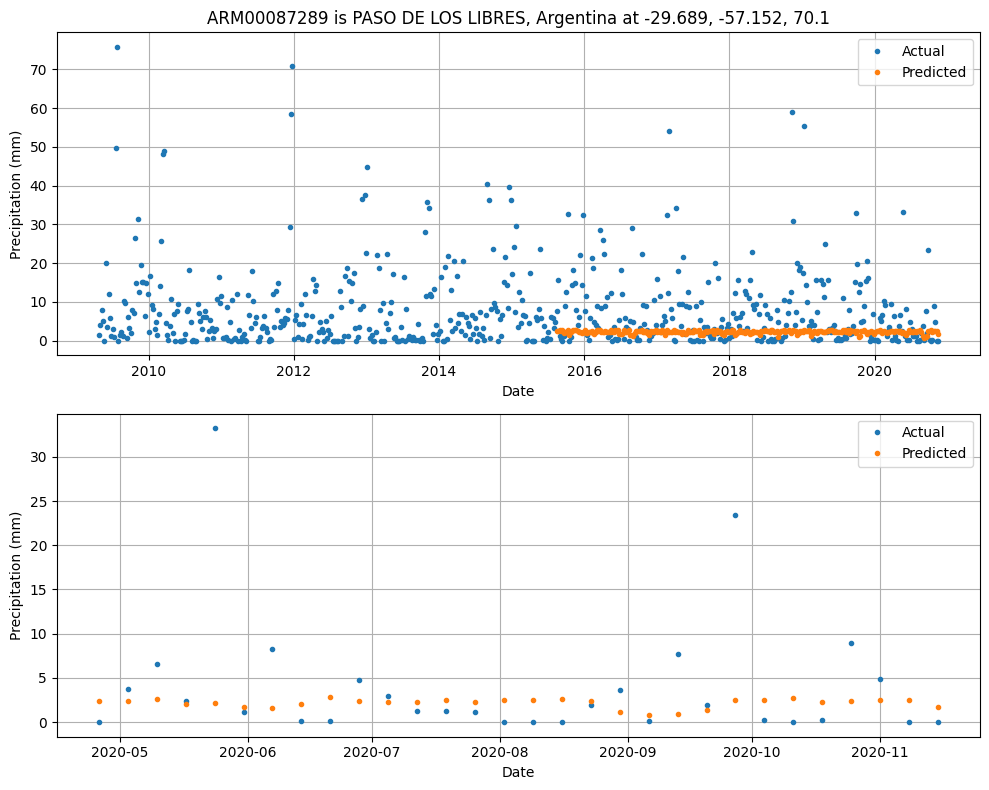

In [15]:
# Plot and compare
dfp = GHCNd_predict_plot(element,test_input,dfis,timeframe, zoom = 30)

# Station 219 Snow

Number of sub datasets is 1
96


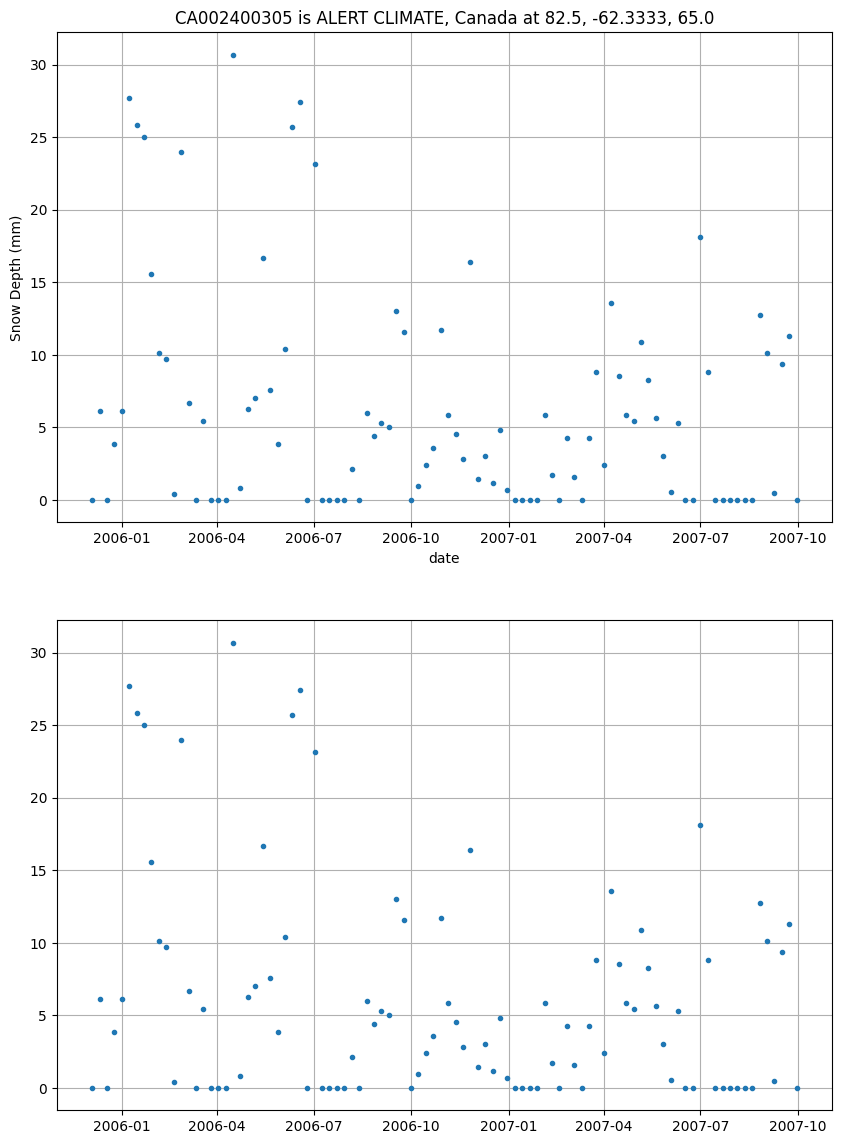

In [48]:
#Define all vars
station = 219
element = 'SNOW'
max_gap = 64
min_length = 365
timeframe = 'W'

# Pull data and train model
indexs,dfis = GHCNd_predict_load_data(station,element,max_gap,min_length,timeframe)

In [49]:
# Reset and train model
model = Delphi()
model.compile(loss='mean_squared_error', optimizer='adam')
test_input = GHCNd_predict_train(indexs, dfis, offset = 52, window_size = 12, train_ratio = 0.7, val_ratio = 0.15, batch_size = 20, epochs = 20)

Epoch 1/20
2/2 [==============================] - 13s 2s/step - loss: 45.8334 - val_loss: 7.0958e-04
Epoch 2/20
2/2 [==============================] - 0s 46ms/step - loss: 50.9635 - val_loss: 0.0044
Epoch 3/20
2/2 [==============================] - 0s 44ms/step - loss: 45.1245 - val_loss: 0.0105
Epoch 4/20
2/2 [==============================] - 0s 44ms/step - loss: 45.1807 - val_loss: 0.0174
Epoch 5/20
2/2 [==============================] - 0s 46ms/step - loss: 46.6803 - val_loss: 0.0282
Epoch 6/20
2/2 [==============================] - 0s 43ms/step - loss: 47.6477 - val_loss: 0.0357
Epoch 7/20
2/2 [==============================] - 0s 46ms/step - loss: 48.8002 - val_loss: 0.0415
Epoch 8/20
2/2 [==============================] - 0s 49ms/step - loss: 49.7093 - val_loss: 0.0512
Epoch 9/20
2/2 [==============================] - 0s 46ms/step - loss: 41.1620 - val_loss: 0.0719
Epoch 10/20
2/2 [==============================] - 0s 44ms/step - loss: 46.0619 - val_loss: 0.0894
Epoch 11/20
2/2 

1/1 [==============================] - 2s 2s/step
rms of test set is 8.413580910902576


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


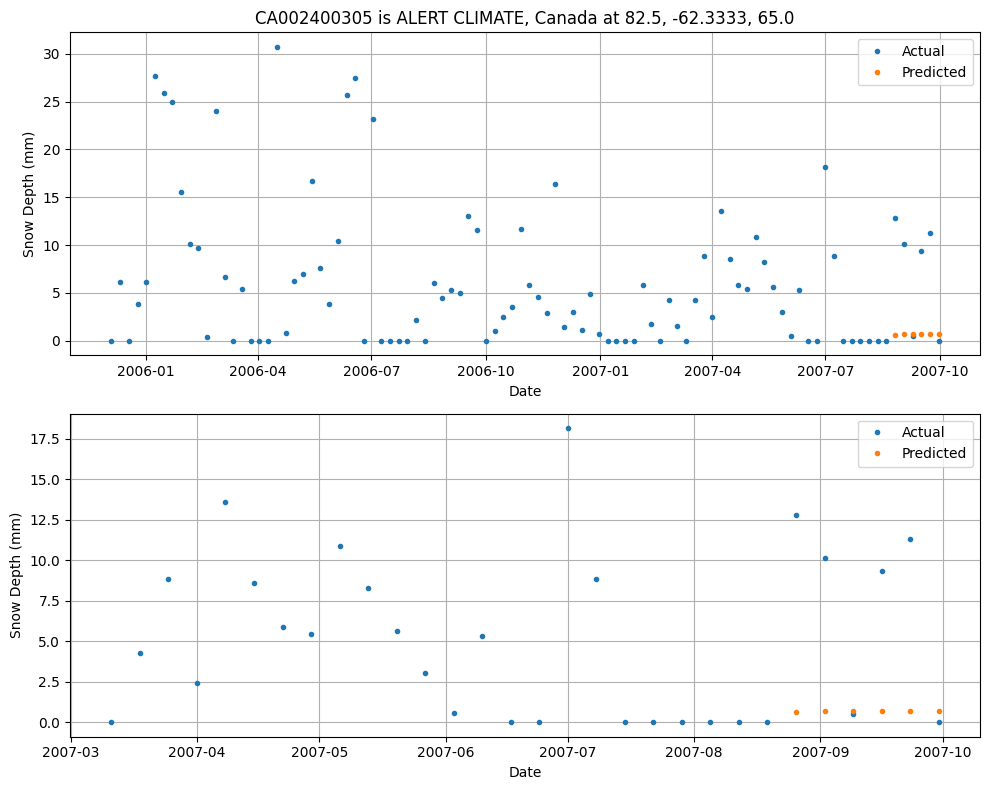

In [50]:
# Plot and compare
dfp = GHCNd_predict_plot(element,test_input,dfis,timeframe, zoom = 30)

#6: Task 2
In this part I'll be pitting my LSTM with offset of one day against a simple guessing model where a days climate will be the same as the day before by compairng their loss functions.

In [16]:
# Simple guess function
def day_before(dfis):
    '''
    For every second datapoint in the last dataframe, copies datapoint before.
    Then takes rms of the simple prediction to be compared with model under test set
    '''
    df = dfis[-1].copy()
    dfc = dfis[-1]
    # Replace every second value with the first value
    if len(df[1::2]) != len(df[::2]): # Deal with rounding errors
      df = df[1:]
    df[1::2] = df[::2].values

    # Calculate the root mean square (RMS) between df and dfc
    if len(df) != len(dfc): # Deal with rounding errors
      dfc = dfc[1:]
    rms = np.sqrt(np.mean((df.values - dfc.values)**2))
    print(f'rms between simple prediction and actual data is {rms}')
    return (df)

# Station 900 TMAX

Number of sub datasets is 1
30574


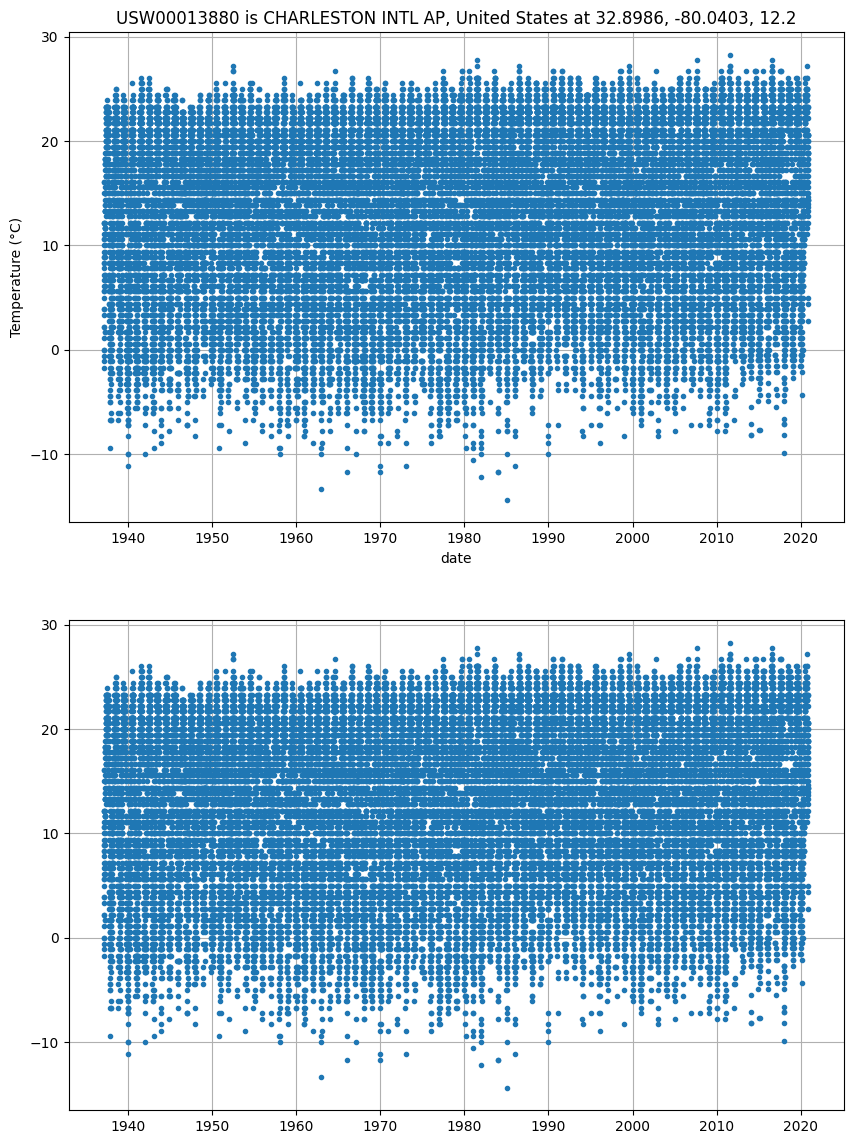

In [51]:
#Define all vars
station = 900
element = 'TMIN'
max_gap = 64
min_length = 365
timeframe = 'D'

# Pull data and train model
indexs,dfis = GHCNd_predict_load_data(station,element,max_gap,min_length,timeframe)

In [52]:
# Reset and train model
model = Delphi()
model.compile(loss='mean_squared_error', optimizer='adam')
test_input = GHCNd_predict_train(indexs, dfis, offset = 1, window_size = 4, train_ratio = 0.7, val_ratio = 0.15, batch_size = 20, epochs = 20)

Epoch 1/20
1070/1070 [==============================] - 34s 19ms/step - loss: 57.2556 - val_loss: 13.2065
Epoch 2/20
1070/1070 [==============================] - 20s 19ms/step - loss: 20.3977 - val_loss: 10.7956
Epoch 3/20
1070/1070 [==============================] - 20s 18ms/step - loss: 18.4339 - val_loss: 11.4381
Epoch 4/20
1070/1070 [==============================] - 19s 18ms/step - loss: 18.5450 - val_loss: 10.5764
Epoch 5/20
1070/1070 [==============================] - 19s 18ms/step - loss: 17.6879 - val_loss: 11.3255
Epoch 6/20
1070/1070 [==============================] - 19s 17ms/step - loss: 17.2413 - val_loss: 10.4516
Epoch 7/20
1070/1070 [==============================] - 19s 18ms/step - loss: 17.4280 - val_loss: 11.8059
Epoch 8/20
1070/1070 [==============================] - 19s 18ms/step - loss: 17.2591 - val_loss: 10.3455
Epoch 9/20
1070/1070 [==============================] - 19s 17ms/step - loss: 17.2381 - val_loss: 10.2587
Epoch 10/20
1070/1070 [=======================

rms between simple prediction and actual data is 2.477921882048683
144/144 [==============================] - 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


rms of test set is 3.1444629682245253


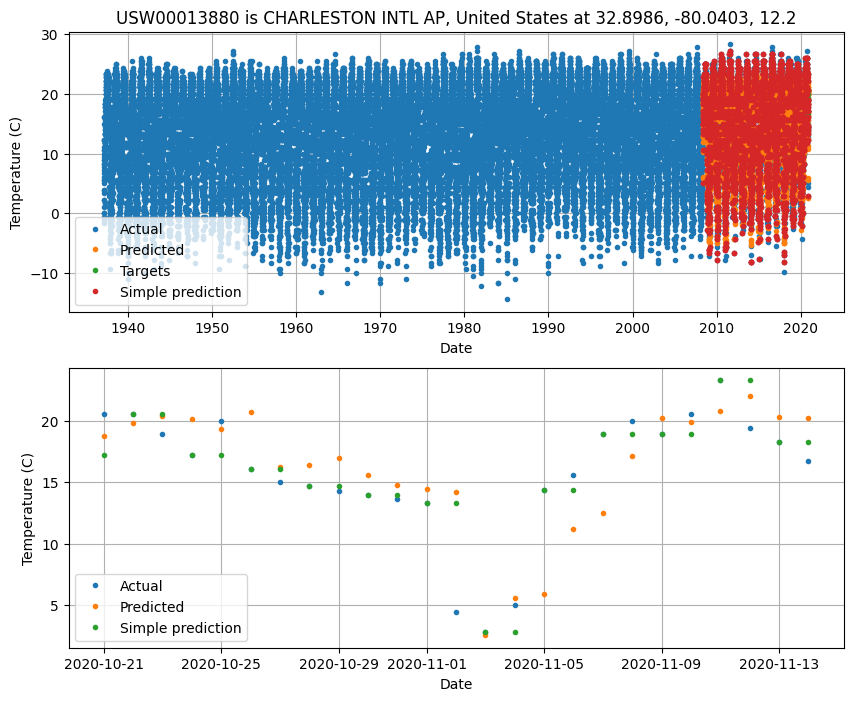

In [54]:
# Plot and compare
dfsp = day_before(dfis)
dfp,rmsm = model_test(test_input,dfis,indexs,timeframe)

# Plot the actual and predicted values
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(dfis[-1][:-offset], '.', label="Actual")
ax[0].plot(dfp, '.', label="Predicted")
ax[0].plot(dfis[-1][-offset:], '.', label="Targets")
ax[0].plot(dfsp[-len(dfp):], '.', label="Simple prediction")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[station]))
ax[0].legend()
ax[0].grid(True)

# Plot the zoom in
zoom = 25 #plot last x number of points
ax[1].plot(dfis[-1][-zoom:], '.', label="Actual")
ax[1].plot(dfp[-zoom:], '.', label="Predicted")
ax[1].plot(dfsp[-zoom:], '.', label="Simple prediction")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Temperature (C)")
ax[1].legend()
ax[1].grid(True)

# Station 100 PRCP

KeyError occurred for SNOW
KeyError occurred for SNWD
Number of sub datasets is 1
27111


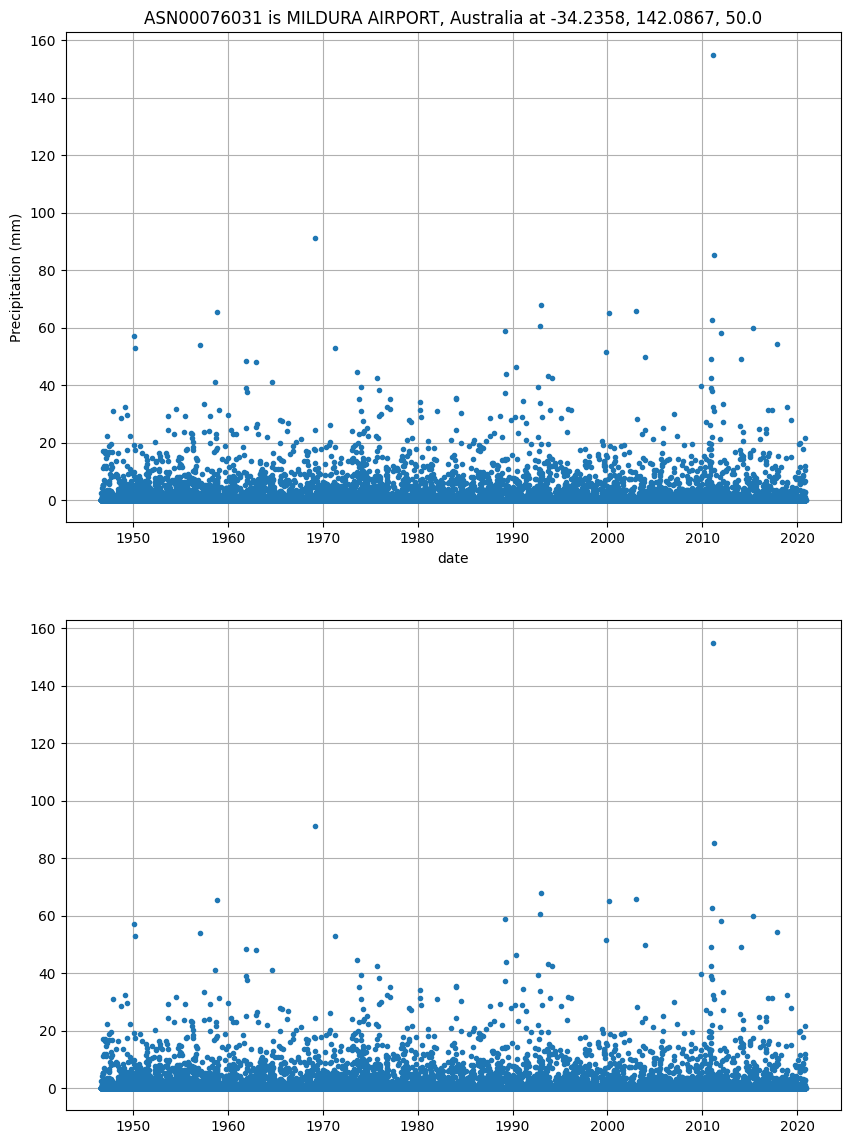

In [56]:
#Define all vars
station = 100
element = 'PRCP'
max_gap = 64
min_length = 365
timeframe = 'D'

# Pull data and train model
indexs,dfis = GHCNd_predict_load_data(station,element,max_gap,min_length,timeframe)

In [57]:
# Reset and train model
model = Delphi()
model.compile(loss='mean_squared_error', optimizer='adam')
test_input = GHCNd_predict_train(indexs, dfis, offset = 1, window_size = 7, train_ratio = 0.7, val_ratio = 0.15, batch_size = 20, epochs = 20)

Epoch 1/20
949/949 [==============================] - 31s 20ms/step - loss: 11.7645 - val_loss: 8.5292
Epoch 2/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1853 - val_loss: 8.2106
Epoch 3/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1668 - val_loss: 8.7380
Epoch 4/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1704 - val_loss: 8.3948
Epoch 5/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1483 - val_loss: 8.7654
Epoch 6/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1570 - val_loss: 8.4463
Epoch 7/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1406 - val_loss: 8.4007
Epoch 8/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1380 - val_loss: 8.4715
Epoch 9/20
949/949 [==============================] - 17s 18ms/step - loss: 11.1192 - val_loss: 8.5824
Epoch 10/20
949/949 [==============================] - 17s 18ms/step - lo

rms between simple prediction and actual data is 3.12454340544679
128/128 [==============================] - 1s 10ms/step
rms of test set is 4.541415805739935


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


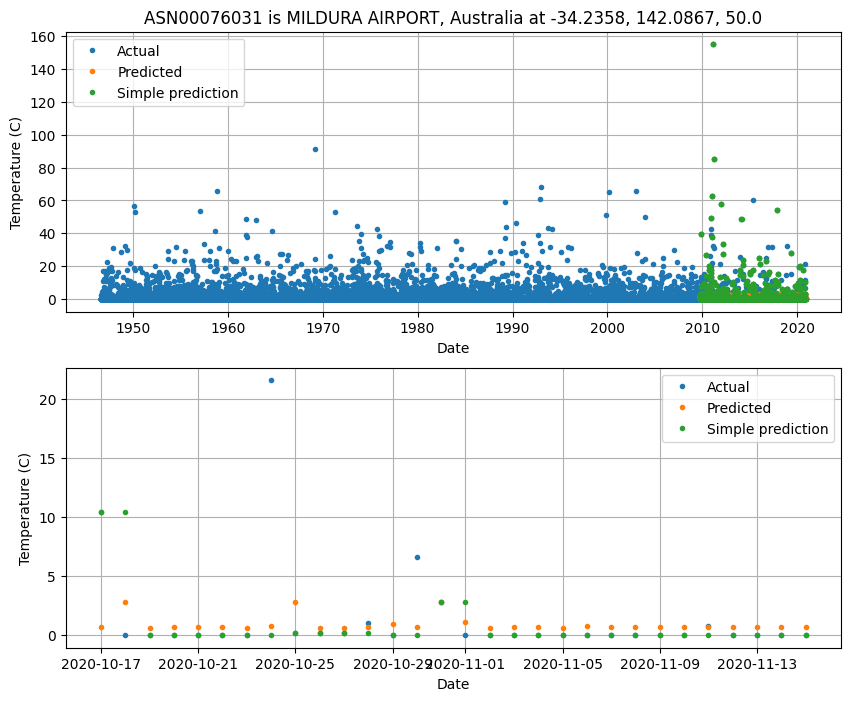

In [60]:
# Plot and compare
dfsp = day_before(dfis)
dfp,rmsm = model_test(test_input,dfis,indexs,timeframe)

# Plot the actual and predicted values
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(dfis[-1], '.', label="Actual")
ax[0].plot(dfp, '.', label="Predicted")
ax[0].plot(dfsp[-len(dfp):], '.', label="Simple prediction")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[station]))
ax[0].legend()
ax[0].grid(True)

# Plot the zoom in
zoom = 30 #plot last x number of points
ax[1].plot(dfis[-1][-zoom:], '.', label="Actual")
ax[1].plot(dfp[-zoom:], '.', label="Predicted")
ax[1].plot(dfsp[-zoom:], '.', label="Simple prediction")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Temperature (C)")
ax[1].legend()
ax[1].grid(True)

KeyError occurred for SNOW
Number of sub datasets is 1
1019


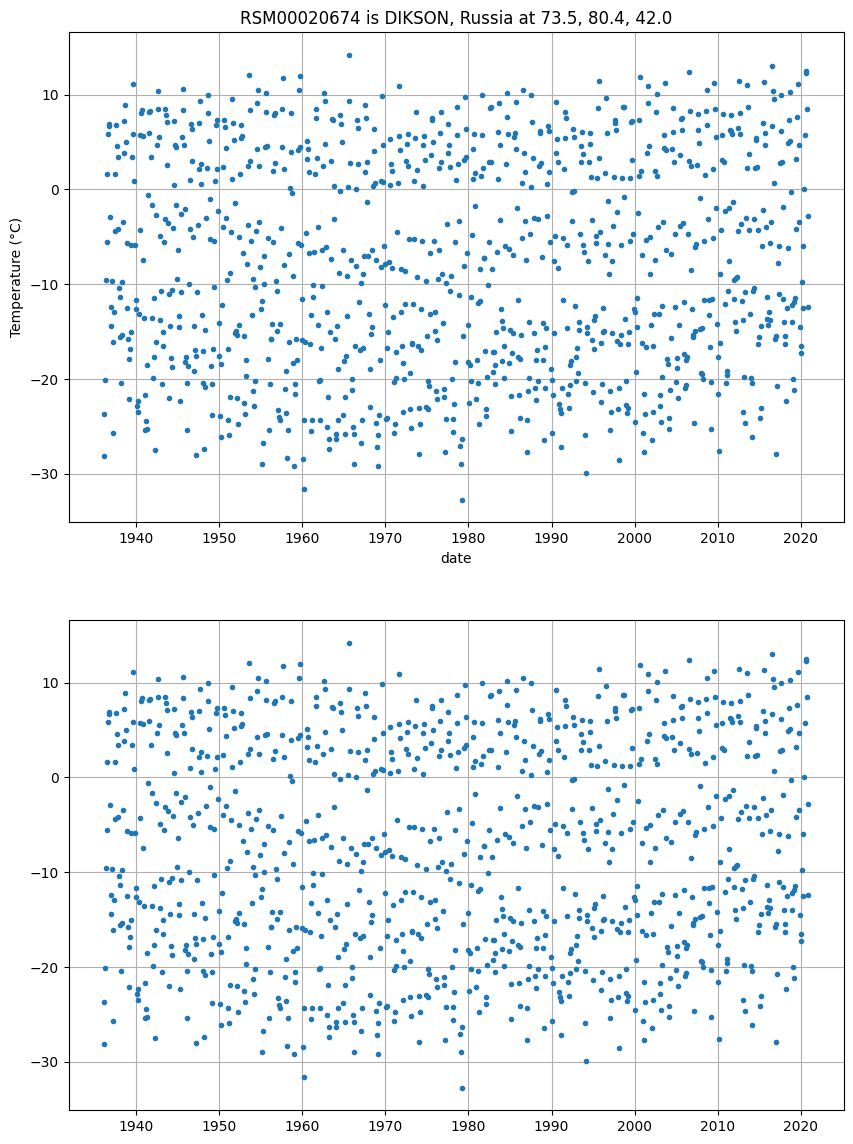

In [32]:
# Cell used to plot sttaion data and find good datasets
#Define all vars
station = 660
element = 'TMAX'
max_gap = 64
min_length = 365
timeframe = 'M'

# Pull data and train model
indexs,dfis = GHCNd_predict_load_data(station,element,max_gap,min_length,timeframe)

In [23]:
# #Couldn't get to work in time
# #Still WIP
# def clothos_wheel(dfp,window_size,offset,timeframe,length):
#   'Recycle predicted data and use it as new input'

#   index = dfp.index
#   data = dfp.iloc[:,0]
#   while index[-1] < length:
#     next_step = table_for_one(dfp,window_size,offset,0,0) #Takes new dataframe and prepares it
#     indexo = index[-1] + relativedelta(months = offset)
#     indexio = (indexo,indexo)
#     dfp,rms = model_test(next_step['test_input'],dfis,(indexio,indexio),'M') #Index array to adapt to code from origianl function
#     print(index[-1])
#     new_data = pd.DataFrame(data,index=index)
#     pd.concat([dfp,new_data])

#   return(dfp)

# twenty_year_tmax = clothos_wheel(dfp,window_size,offset,'M',dfp.index[-1] + relativedelta(years =+ 20))

In [24]:
# plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# plt.plot(twenty_year_tmax, '.-')  # Plotting the data points
# plt.title('Twenty Year Tmax Data')  # Adding title
# plt.xlabel('Time')  # Labeling x-axis
# plt.ylabel('Tmax')  # Labeling y-axis
# plt.grid(True)  # Adding grid
# plt.show()

# print(twenty_year_tmax.tail())